# Mandatory assignment 3 by Abdullah Karagøz </h1>
## Introduction
In this assignment I'm going to solve the MNIST classification task by classifying the given handwritten digit into one of 10 integer classes (0-9). I'll use the small version (200 samples) of the original dataset.

In this assignment I'm expected to:
1. Perform data preprocessing on the given dataset before feeding the data into the model.
2. Develop a deep learning model from scratch to solve this classification task.
3. Split the dataset into Train/Validation/Test examples.
4. Train and evaluate your model to establish a baseline of performance.
5. Finalize your model to make predictions on new images.
6. Tweak the network's hyper-parameters to make the model overfit and underfit.
7. Diagnose the model for each case (overfit/underfit), and explain the model's behavior by using
the learning curves.
8. Benchmark your model's performance using SGD, Momentum, and ADAM optimization
techniques

## Goal
So the goal is to build a neural network model using a framework to solve a more complex classification task, experiment with the model and analyze the results.

## Method
I decided to use PyTorch. In my perception PyTorch is more simple than TensorFlow, and guide on PyTorch was more clear and easy to understand.

I both check prediction accuracy and Cross Entropy Loss to measure performance. But the set is just 200 samples, and test set will be even smaller (30 samples). Because of too little sample, I'll use Cross Entropy Loss to measure performance because it's more correct.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms

import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# This is to make it more reproductible, taken from https://pytorch.org/docs/stable/notes/randomness.html
seed = 3

import random
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# The function and generator will be used when generating dataloaders as parameters
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

# 1. Data processing
## Perform data preprocessing on the given dataset before feeding the data into the model.
The MNIST dataset should be clean. But still I'll do some check to see how the data looks like.

In [3]:
# Loading data to pandas
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/MNIST_dataset.csv')

In [4]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,labels
count,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,...,200.000000,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.0,200.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.640000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.385000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.050967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.813602
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000


In [5]:
# Checking if there are missing data using Pandas dataframe
print("Any null value: ",df.isnull().values.any())
print("Any value that's not integer or float: ", df.select_dtypes(exclude=['int','float']).values.any())
test = pd.DataFrame([[1,0,3,5],[1,0,0,3],[0,0,0,4], [0,0,0,0]])

print("Any rows with only zeros:", (df.iloc[:, :784] == 0).all(axis=1).values.any())

#Convert to tensor and check the data
dataset = torch.tensor(df.to_numpy(), dtype=torch.float)
print(dataset.shape)
dataset

Any null value:  False
Any value that's not integer or float:  False
Any rows with only zeros: False
torch.Size([200, 785])


tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 2.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 6.],
        [0., 0., 0.,  ..., 0., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 2.]])

In [6]:
## Rescaling the data by dividing all pixels by 255
dataset[:, :784] /= 255

dataset

tensor([[0., 0., 0.,  ..., 0., 0., 7.],
        [0., 0., 0.,  ..., 0., 0., 2.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 6.],
        [0., 0., 0.,  ..., 0., 0., 4.],
        [0., 0., 0.,  ..., 0., 0., 2.]])

image shape:  torch.Size([200, 784])
labels shape:  torch.Size([200])


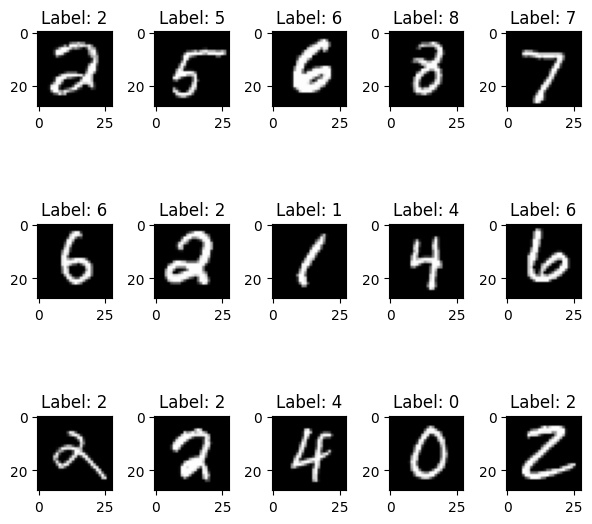

In [7]:
# Here we check if images and labels are consistent by picking random values.

# This is taken and edited from https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/
num_col = 5
num_row = 3

r = np.random.randint(0, 200, num_col*num_row)
images = dataset[:, :784]
labels = dataset[:, 784]
print("image shape: ", images.shape)
print("labels shape: ", labels.shape)


fig, axes = plt.subplots(num_row, num_col, figsize=(6, 6))
for i in range(len(r)):
  image = images[r[i]]
  label = labels[r[i]]
  image = image.reshape(28, 28)
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image, cmap='gray')
  ax.set_title('Label: {}'.format(int(label)))
fig.tight_layout(pad=1.0)



# 2. Developing the learning model
## Develop a deep learning model from scratch to solve this classification task.
Before building the learning model, I first build some functions that'll run the training and testing. That's to make the code more simpler.

Below is the function that uses Pytorch to train the model and test the model.

Training and validation is implemented together. While training after each iteration we test the model (validation) and get the mean CEL into a list. That is to see how on each iteration mean CEL on training and validation changes, so that we can ovserve eventual overfit.

In train and validation we only measure mean CEL.

In test function we measure both mean CEL and accuracy. As mentioned we'll use mean CEL or CEL to measure performance, but we'll look into accuracy too.

In [8]:
# Training function

def training(num_epochs, model, optimizer, criterion, train_loader, valid_loader):
  results = list()
  valid_results = list()
  #model.float()
  for ep in range(num_epochs):
    running_loss = 0
    valid_loss = 0
    model.train() # Set model into training mode
    for batch in train_loader:
      # We extract the images and labels from the batch
      images = batch[:, :784]
      labels = batch[:, 784]
      labels = torch.tensor(labels, dtype=torch.long)
      # This will prevent the gradient descents from the previous batches to accumulate. Without this the weight will get updated with the sum of
      # all previos gradient descents, instead of the gradient descents on the current batch.
      optimizer.zero_grad()
      output = model(images) # prediction / output from the model

      loss = criterion(output, labels)  # We calculate the loss here
      loss.backward() # Computes the derivative of the loss using backpropagation.
      optimizer.step() # We update the weights

      running_loss += loss.item() # Sum the loss here
    else:
      results.append(running_loss / len(train_loader))  # We append the mean loss into a list

    # Validation part
    model.eval()
    with torch.no_grad(): # This will prevent calculation of gradient descents
      for batch in valid_loader:
        images = batch[:, :784]
        labels = batch[:, 784]
        valid_output = model(images) # Prediciton
        loss = criterion(valid_output, labels.long()) # Calculation of loss
        valid_loss += loss.item() # Sum the loss
      else:
        valid_results.append(valid_loss / len(valid_loader)) # Here we calculate the mean loss
  return results, valid_results



In [9]:
# testing function

def testing(model, criterion, test_loader):
  model.eval() # Set model into evaluation model
  test_loss = 0
  total = 0
  correct = 0
  with torch.no_grad(): # This will prevent calculation of gradient descents
    for batch in test_loader:
       images = batch[:, :784]
       labels = batch[:, 784]
       test_output = model(images) # Prediciton
       loss = criterion(test_output, labels.long()) # Calculation of loss
       test_loss += loss.item() # Sum the loss
       # Calculating accuracy, taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
       _, predicted = torch.max(test_output.data, 1)
       total += labels.size(0)
       correct += (predicted == labels).sum().item()
    else:
      mean_test_loss = test_loss / len(test_loader) # Here we calculate the mean loss
  return mean_test_loss, total, correct

Below is the network. It has 2 hidden layers to make the learning better, because I think predicting the number from image of 784 pixels is more complicated than predicting class of Iris plant by 4 features.

The model built looks like this:
* 784 nodes (input values) with 256 nodes
* ReLU activation function
* then 256 nodes connected to 128
* Tanh activation function
* Then 128 nodes connected to 10 output nodes.

The output nodes show a probability distribution what digit a given picture is.

First Activation is ReLU. ReLU is simple, it just returns looks like this:

`Return X if X > 0, else return 0.`

Then it uses Tanh. Function of Tanh looks like this: $\sigma(x)=\frac{e2x-1}{e2x+1}$

And its derivative looks like: $\sigma'(x) = 1 - \sigma^2$

I tried only ReLU too, but adding Tanh at the end improved performance. I experimented both with Sigmoid and Tanh, and with Tanh the results were slightly better.

I tried only ReLU too, but adding Tanh at the end improved performance. I experimented both with Sigmoid and Tanh, and with Tanh the results were slightly better.



In [10]:
# Neural Network model, putting in a function to make the code more clean
def get_model():
  return nn.Sequential(nn.Linear(784, 256),
                       nn.ReLU(),
                       nn.Linear(256, 128),
                       nn.Tanh(),
                       nn.Linear(128, 10))

# 3. Split the dataset into Train/Valid/Test examples
We first split the data into "training" and "testing" set by 17:3 ratio (85% training and 15% testing)

Then we split the training set further into "training" and "validation" set by 7:3 split (70% training and 30% validation).

The set is too small, so I made the training and validataion a little bigger.

The validation is used while we tune the hyper-parameters (learning rate, number of layers, nodes, activation functions, epochs, batch etc.). And testing is used at the end. The reason for this division between "validation" and "testing" is that while we use validation to optimize hyper-parameters, we don't want our model be biased towards validation set. That's just like we don't want our model to be biased towards training set while training the data and updating the weights.

Since the sample size is 200, I decided to use the batch size as 8, as 200 can be divided by 8. So what we use is mini-Batch Stocahstic Gradient Descent since we are using batch size that's higher than one.

In [11]:
# Split rate, 30% of training data will be used as validation.
train_test_split = 0.15
train_valid_split = 0.3

# Splitting the data
train_dataset, testing_dataset = torch.utils.data.random_split(dataset, [int(round((1-train_test_split)*len(dataset))), int(round(train_test_split*len(dataset)))])

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [int(round((1-train_valid_split)*len(train_dataset))), int(round(train_valid_split*len(train_dataset)))])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, worker_init_fn = seed_worker, generator=g)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, worker_init_fn = seed_worker, generator=g)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=False)

# 4. Train and evaluate your model to establish a baseline of performance.

As criterion of loss, we use Cross Entropy Loss. CEL is used on categorical classification, and in this case this is what we do. We categories images on a digit (a digit between 0 and 9).

CEL looks like this: $L=-\sum_{i=1}^N y_i\log(a_i)$

Where M is the number of classes (10 in your case) y is the probability of the true label being class c (binary 0 or 1) and p is the probability of the prediction being of class c by your classifier
*   $N$ is the number of classes (10 in this case)
*   $y_i$ is the probability of the true label being class i (it's binary' either 0 or 1)
*   $a_i$ is the probability of the prediction being of class i by the classifier (the model).

Also, if let's say the correct class of given picture is 7. And the probability of it being seven is 0.4. Then the loss is $1log(0.4)$. Since $y_i$ is 0 in all other classes, the values of the product  $y_i\log(a_i)$ will be zero.

As optimizer we choose Stochastic Gradient Descent, with learning rate = 0.006.

We choose epoch = 100. Too high epoch causes overfitting.


In [12]:
learning_rate = 0.006

num_epochs = 100

criterion = nn.CrossEntropyLoss()

model = get_model()

optimizer = optim.SGD(model.parameters(), lr = learning_rate)

Here we train the model, and run the validation. Then we tune the hyper parameters of the model, and train and run the validation again. There are some frameworks to automatize tuning, but I tuned the model manually.

/tmp/ipython-input-3591804208.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


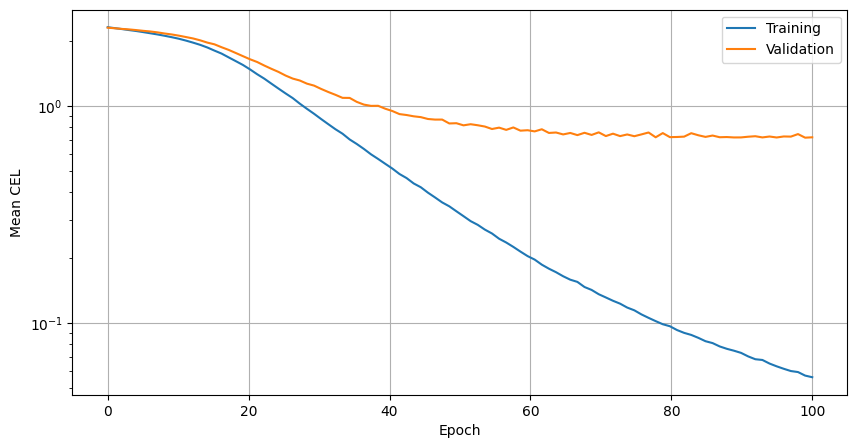

In [13]:
sgd_results, sgd_valid_loss = training(num_epochs, model, optimizer, criterion, train_loader, valid_loader)

x_axis = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x_axis, sgd_results, label='Training')
ax.plot(x_axis, sgd_valid_loss, label='Validation')
ax.set_ylabel("Mean CEL")
ax.set_xlabel("Epoch")
ax.grid()

ax.set_yscale('log')
#ax.set_xscale('log')

plt.legend()

plt.show()


In [14]:
mean_test_loss, total, correct = testing(model, criterion, test_loader)

print("The mean CEL from the test is ", mean_test_loss)

print("{} out of {} is predicted correctly".format(correct, total))



The mean CEL from the test is  0.5395772699266672
26 out of 30 is predicted correctly


# 5. Finalize your model to make predictions on new images.

Here we test the and see how it predicts with random images.



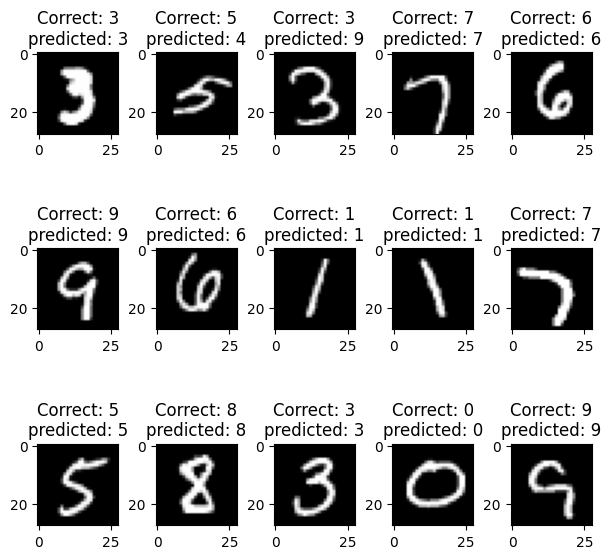

In [15]:
# This is taken and edited from https://mrdatascience.com/how-to-plot-mnist-digits-using-matplotlib/
num_col = 5
num_row = 3

r = np.random.randint(0, 200, num_col*num_row)
images = dataset[:, :784]
labels = dataset[:, 784]

model.eval()

fig, axes = plt.subplots(num_row, num_col, figsize=(6, 6))
for i in range(len(r)):
  image = images[r[i]]
  label = labels[r[i]]
  prob = model(image)
  _, pred = torch.max(prob.data, 0)
  image = image.reshape(28, 28)
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image, cmap='gray')
  ax.set_title('Correct: {}\npredicted: {}'.format(int(label), int(pred)))
fig.tight_layout(pad=0.6)


# 6. Tweak the network's hyper-parameters to make the model overfit and underfit

Here's an example of overfitting and underfitting. With overfitting we set the epoch = 1000, and learning rate = 0.3. Too high learning rate causes that the model fails to learn, it just oscillatis around.

Everything else is equal. With underfitting epoch = 10 and learning rate = 0.0005.

Then we compare them by ploting the loss curves from training and the test results.

In [16]:
# Overfitting
num_epochs_high = 1000

model = get_model()

training_results_overfit, valid_results_overfit = training(num_epochs_high, model, optim.SGD(model.parameters(), lr = 0.3), criterion, train_loader, valid_loader)

mean_loss_overfit, total_overfit, correct_overfit = testing(model, criterion, test_loader)

# Underfitting
model = get_model()

num_epochs_low = 10

training_results_underfit, valid_results_underfit = training(num_epochs_low, model, optim.SGD(model.parameters(), lr = 0.0005), criterion, train_loader, valid_loader)

mean_loss_underfit, total_underfit, correct_underfit = testing(model, criterion, test_loader)


/tmp/ipython-input-3591804208.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


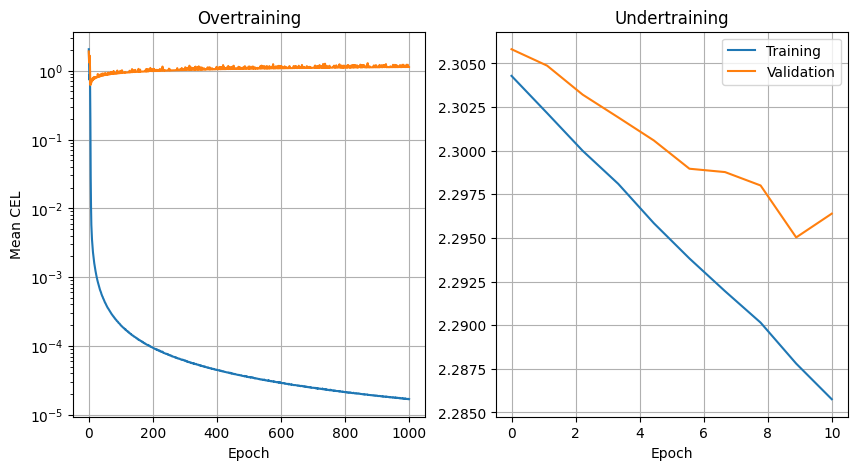

Overfitting: 
Mean CEL:  1.021269939483318
Accuracy: 25/30 

Underfitting: 
Mean CEL:  2.298885762691498
Accuracy: 4/30 


In [17]:
#Code to plot
x_overfit = np.linspace(0, num_epochs_high, num_epochs_high)

x_underfit = np.linspace(0, num_epochs_low, num_epochs_low)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(x_overfit, training_results_overfit, label='Training')
ax[0].plot(x_overfit, valid_results_overfit, label='Validation')
ax[0].set_title("Overtraining")
ax[0].set_ylabel("Mean CEL")
ax[0].set_xlabel("Epoch")
ax[0].grid()
ax[1].plot(x_underfit, training_results_underfit, label = 'Training')
ax[1].plot(x_underfit, valid_results_underfit, label = 'Validation')
ax[1].set_title("Undertraining")
ax[1].set_xlabel("Epoch")
ax[1].grid()

ax[0].set_yscale('log')
#ax[1].set_yscale('log')

#ax.set_xscale('log')

plt.legend()

plt.show()

print("Overfitting: ")
print("Mean CEL: ", mean_loss_overfit)
print("Accuracy: {}/{} ".format(correct_overfit, total_overfit))
print("\nUnderfitting: ")
print("Mean CEL: ", mean_loss_underfit)
print("Accuracy: {}/{} ".format(correct_underfit, total_underfit))

# 7. Diagnose the model for each case (overfit/underfit), and explain the model's behavior by using the learning curves.

## Underfitting

In underfitting the model gives high CEL when we try it both in training set and testing set. Also it means the model did not have an opportunity to "learn" well from the training data.It has too few epochs to learn and the learning rate was too small. There was not enough opportunity to minimize the loss.

## Overfitting

In overfitting training error keeps progressing ever closer to zero, but validation error falls and then begins to climb as our model overfits the training data and generalizes less well to the validation data!

When the model overfits it's essntially modeling the noise in the training data and, as a result, the model cannot generalize well to other data sets.

In overfitting the model gives very low CEL when we try it on the training set. But the CEL is far higher when we run it on the testing set. This means the model did learn very well on the training set. That's because we used very high epoch (with high enough learning rate). It iterated so many times that the the model learned the training set well. But the model become biased: it assumes as if all data is just like the training set. So when using validation set and testing set, it scores low. This is the reason we split the training set between validation set.

However when we tune the hyper-parameters, we may tune them too much that it performs well on the validation set. But in other data it may perform poorly. That's why we also have a testing set.

The model behaves as if all data in the world is just like the training set, causing very high bias (biased to act as everything is equal to the training set) and give loss when testing on data that's not exact like training set.

As we see on the results, high learning rate and high epochs causes overfitting. With overfitting, the CEL reduces very quickly in training. It may even reduce below $10^{-2}$ in the training set, but the error is ca 0.5-0.6 when testing which is far higher.



# 8. Benchmark your model's performance using SGD, Momentum, and ADAM optimization techniques.

Here we use same hyper-paremeters and model as we used in the first part. But we compare different optimization methods, Stocahstic Gradient Descent, Momentum and ADAM. The Momentum and hyper-parameters are chosen after some tuning of the parameters.




In [18]:
# Training with SGD and then testing
model = get_model()
optim_SGD = optim.SGD(model.parameters(), lr = learning_rate)

training_results_SGD, valid_results_SGD = training(num_epochs, model, optim_SGD, criterion, train_loader, valid_loader)
mean_loss_SGD, total_SGD, correct_SGD = testing(model, criterion, test_loader)

# Training with Momentum and then testing
model = get_model()
optim_Momentum = optim.SGD(model.parameters(), momentum=0.9, lr = learning_rate)

training_results_Momentum, valid_results_Momentum = training(num_epochs, model, optim_Momentum, criterion, train_loader, valid_loader)
mean_loss_Momentum, total_Momentum, correct_Momentum = testing(model, criterion, test_loader)

# Training with ADAM and then testing
model = get_model()
optim_ADAM = optim.Adam(model.parameters(), lr = learning_rate, betas=(0.9, 0.99))

training_results_ADAM, valid_results_ADAM = training(num_epochs, model, optim_ADAM, criterion, train_loader, valid_loader)
mean_loss_ADAM, total_ADAM, correct_ADAM = testing(model, criterion, test_loader)

/tmp/ipython-input-3591804208.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


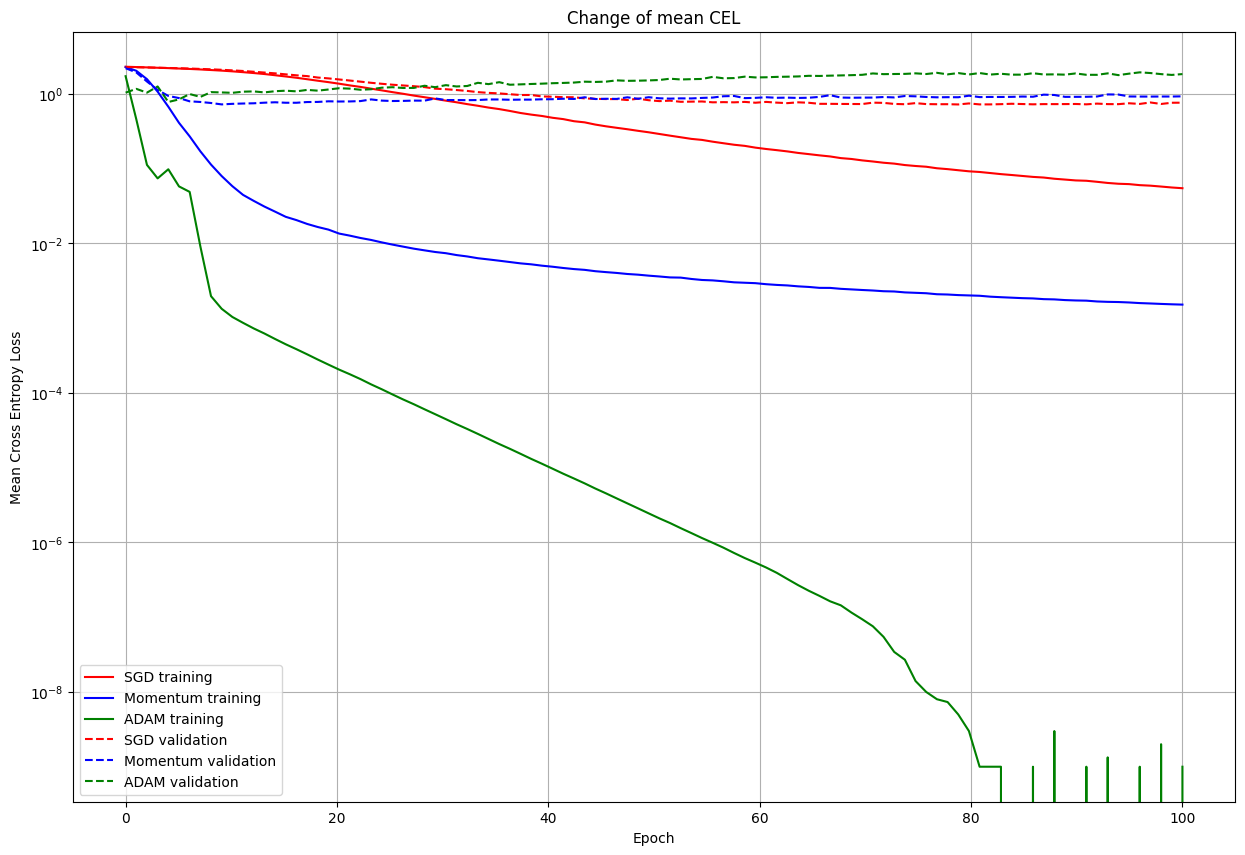

| Optimization method   |   CEL | Accuracy   |
|-----------------------+-------+------------|
| SGD                   |  0.54 | 26/30      |
| Momentum              |  0.63 | 24/30      |
| ADAM                  |  1.31 | 25/30      |


In [19]:
#Code to plot
x = np.linspace(0, num_epochs, num_epochs)

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(x, training_results_SGD, color='r', label='SGD training')
ax.plot(x, training_results_Momentum, color='b', label = 'Momentum training')
ax.plot(x, training_results_ADAM, color='g', label = 'ADAM training')
ax.plot(x, valid_results_SGD, color='r', linestyle='dashed', label='SGD validation')
ax.plot(x, valid_results_Momentum, color='b', linestyle='dashed', label = 'Momentum validation')
ax.plot(x, valid_results_ADAM, color='g', linestyle='dashed', label = 'ADAM validation')


ax.set_yscale('log')
#ax.set_xscale('log')

plt.xlabel("Epoch")
plt.ylabel("Mean Cross Entropy Loss")
plt.title("Change of mean CEL")
plt.legend()

plt.grid()
plt.show()

from tabulate import tabulate
table = list()

table.append(["SGD", mean_loss_SGD, "{}/{}".format(correct_SGD, total_SGD)])
table.append(["Momentum", mean_loss_Momentum, "{}/{}".format(correct_Momentum, total_Momentum)])
table.append(["ADAM", mean_loss_ADAM, "{}/{}".format(correct_ADAM, total_ADAM)])

print(tabulate(table, headers=["Optimization method", "CEL", "Accuracy"], tablefmt='orgtbl', floatfmt=".2f"))

Momentum and SGD performs similar, as they are similar to each other. With Momentum adds a fraction of previous update vector to the current
update vector using the "Momentum rate". This is called "decay rate".

Also without momentum:
new weight = old weight - learning rate * gradient

With momentum:
new weight = old weight + learning rate * ((1 - decay rate)*(gradient) + decay rate * previous gradient)

We see from the graph that the mean CEL reduces faster in validation when using Momentum. But CEL increase again maybe because of overfitting. Epoch is too high for Momentum.

ADAM is a more complicated method. It's a combination of RmPROP and Momentum. It uses both gradient and gradient squared. It seems with ADAM the model is learning very fast (the mean CEL of validation reduces after few iterations). But since we use same epoch on all three, it is overfitting and performs worse (gives higher CEL on validation). Maybe it could work better with ADAM if we reduce epochs.

The best here seems to be using Momentum with less epoch, like somewhere between 10-40.

Here the SGD seems to performs best, but that's just because I had tuned the hyper-parameters with SGD. So maybe Momentum or ADAM could perform better if I had tuned hyper-parameters for those.

## Result

The table below summarizes the results.

The dataset is very little for the task (just 200), and there are some images that's far more difficult to predict than others. Thus the results vary a lot each time I run it. It was therefore difficult to tune the parameters. Take the "result" values with some grain of salt, they should not be seen as exact values. If you run the code yourself your results may be far more different.

The mean CEL on training set vs validation set vs testing set vary a lot too. One can see high performance on training set, but then very bad performance on validation or testing. Also the model was very biased. It would be better to use k-fold cross validation in this case to reduce bias.


| Network  (layers and activation functions) | Learning rate | Batch size | Epochs | Weight initalization | Optimization technique | Optim. parameters        | mean CEL | Accuracy |
|--------------------------------------------|---------------|------------|--------|----------------------|------------------------|--------------------------|----------|----------|
| (784,256)- ReLU - 128 - Tanh - 10          | 0.0005        | 8          | 10     | Default              | SGD                    | NaN                      | 2.30     | 4/30    |
| (784,256)- ReLU - 128 - Tanh - 10          | 0.3          | 8          | 1000   | Default              | SGD                    | NaN                      | 0.74     | 25/30     |
| (784,256)- ReLU - 128 - Tanh - 10          | 0.006         | 8          | 100    | Default              | SGD                    | NaN                      | 0.54     | 26/30    |
| (784,256)- ReLU - 128 - Tanh - 10          | 0.006         | 8          | 100    | Default              | Momentum               | Momentum = 0.9           | 0.59     | 24/30    |
| (784,256)- ReLU - 128 - Tanh - 10          | 0.006         | 8          | 100    | Default              | ADAM                   | beta1 = 0.9  beta2 = 0.99 | 1.26     | 24/30    |